In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import argparse
from glob import glob

import torch
from torch_em.data import MinInstanceSampler
import micro_sam.training as sam_training

import albumentations as A

from torch_em.util.debug import check_loader
from torch.utils.data import Dataset
from scipy.ndimage import binary_erosion
import numpy as np
from skimage.measure import label
from skimage.io import imread
import torch_em

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
raw_ds = ('GFP_max', 'GFP_max_clahe')
seg_ds = ('CELL_max', 'CELL_comb', 'CELL_manual')

models = ('vit_t_lm', 'vit_b_lm', 'vit_l_lm')

model = models[0]
raw_dataset = raw_ds[0]
segmentation_gt = seg_ds[2]

root_dir = '/group/jug/Enrico/TISSUE_roi_projection'

In [3]:
#image_dir = '/group/jug/Enrico/TISSUE_roi_projection'
image_dir = root_dir


# Load images from multiple files in folder via pattern (here: all tif files)
raw_key= '*_' + raw_dataset + '.tif'
label_key = '*_' + segmentation_gt + '.tif'


# already splitted into two folders
training_dir = os.path.join(image_dir, "training")
validation_dir = os.path.join(image_dir, "validation")

# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb



# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

In [4]:
batch_size = 1  # the training batch size
patch_shape = (1, 1024, 1024)  # the size of patches for training

train_loader = sam_training.default_sam_loader(
    raw_paths=training_dir,
    raw_key=raw_key,
    label_paths=training_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=validation_dir,
    raw_key=raw_key,
    label_paths=validation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    shuffle=True,
    #raw_transform=sam_training.identity,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

In [5]:
# create a torch dataset
class CellDataset(Dataset):
    def __init__(
        self,
        image_dir,
        mask_dir,
        crop_size=None,
        padding_size=8,
        with_segmentation_decoder=True,
        augmentation=False):

      self.images = list(sorted(glob(image_dir)))
      self.masks = list(sorted(glob(mask_dir)))

      self.crop_size = crop_size
      self.padding_size = padding_size
      self.with_segmentation_decoder = with_segmentation_decoder
      self.augmentation = augmentation


    def __len__(self):
      return len(self.images)

    # function to erode label boundaries
    def erode(self, labels, iterations, border_value):

      foreground = np.zeros_like(labels, dtype=bool)

      # loop through unique labels
      for label in np.unique(labels):

          # skip background
          if label == 0:
              continue

          # mask to label
          label_mask = labels == label

          # erode labels
          eroded_mask = binary_erosion(
                  label_mask,
                  iterations=iterations,
                  border_value=border_value)

          # get foreground
          foreground = np.logical_or(eroded_mask, foreground)

      # and background...
      background = np.logical_not(foreground)

      # set eroded pixels to zero
      labels[background] = 0

      return labels

    # takes care of padding
    def get_padding(self, crop_size, padding_size):
    
        # quotient
        q = int(crop_size / padding_size)
    
        if crop_size % padding_size != 0:
            padding = (padding_size * (q + 1))
        else:
            padding = crop_size
    
        return padding
    
    # sample augmentations (see https://albumentations.ai/docs/examples/example_kaggle_salt)
    def augment_data(self, raw, mask, padding):
        
        transform = A.Compose([
              A.RandomCrop(
                  width=self.crop_size,
                  height=self.crop_size),
              A.PadIfNeeded(
                  min_height=padding,
                  min_width=padding,
                  p=1,
                  border_mode=0),
              A.HorizontalFlip(p=0.3),
              A.VerticalFlip(p=0.3),
              A.RandomRotate90(p=0.3),
              A.Transpose(p=0.3),
              A.RandomBrightnessContrast(p=0.3)
            ])

        transformed = transform(image=raw, mask=mask)

        raw, mask = transformed['image'], transformed['mask']

        # I guess that the training and loader deals with 3d pictures, so it wants another axis
        if len(raw.shape) == 2:
            raw = np.expand_dims(raw, axis=0)
            #mask = np.expand_dims(mask, axis=0)
        
        return raw, mask

    # normalize raw data between 0 and 1
    def normalize(self, data):
      return ((data - np.min(data)) / (np.max(data) - np.min(data))*255).astype(np.float32)

    def __getitem__(self, idx):

      raw = self.images[idx]
      labels = self.masks[idx]

      raw = imread(raw)
      raw = self.normalize(raw)
      
      # slice first channel, relabel connected components
      labels = label(imread(labels)).astype(np.uint16)

      padding = self.get_padding(self.crop_size, self.padding_size)
      if self.augmentation:
        raw, labels = self.augment_data(raw, labels, padding)

      min_size = 25
      if self.with_segmentation_decoder:
        label_transform = torch_em.transform.label.PerObjectDistanceTransform(
            distances=True,
            boundary_distances=True,
            directed_distances=False,
            foreground=True,
            instances=True,
            min_size=min_size,
        )
      else:
        label_transform = torch_em.transform.label.MinSizeLabelTransform(min_size=min_size)
      labels = label_transform(labels).astype(np.float32)

      return raw, labels


In [ ]:
train_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + raw_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_gt + '.tif',
    crop_size=1024, with_segmentation_decoder=True, augmentation=True)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_dataloader.shuffle = True


valid_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + raw_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + segmentation_gt + '.tif',
    crop_size=1024, with_segmentation_decoder=True)

valid_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader.shuffle = True


In [12]:
data_iter = iter(train_loader)
data_iter_new = iter(train_dataloader)

In [13]:
print(type(train_dataloader))
x, y = next(data_iter_new)
print(x.shape)
print(y.shape)
print(x.dtype)
print(y.dtype)

print()


x, y = next(data_iter)
print(x.shape)
print(y.shape)
print(x.dtype)
print(y.dtype)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([1, 1, 1024, 1024])
torch.Size([1, 4, 1024, 1024])
torch.float32
torch.float32

torch.Size([1, 1, 1024, 1024])
torch.Size([1, 4, 1024, 1024])
torch.float32
torch.float32


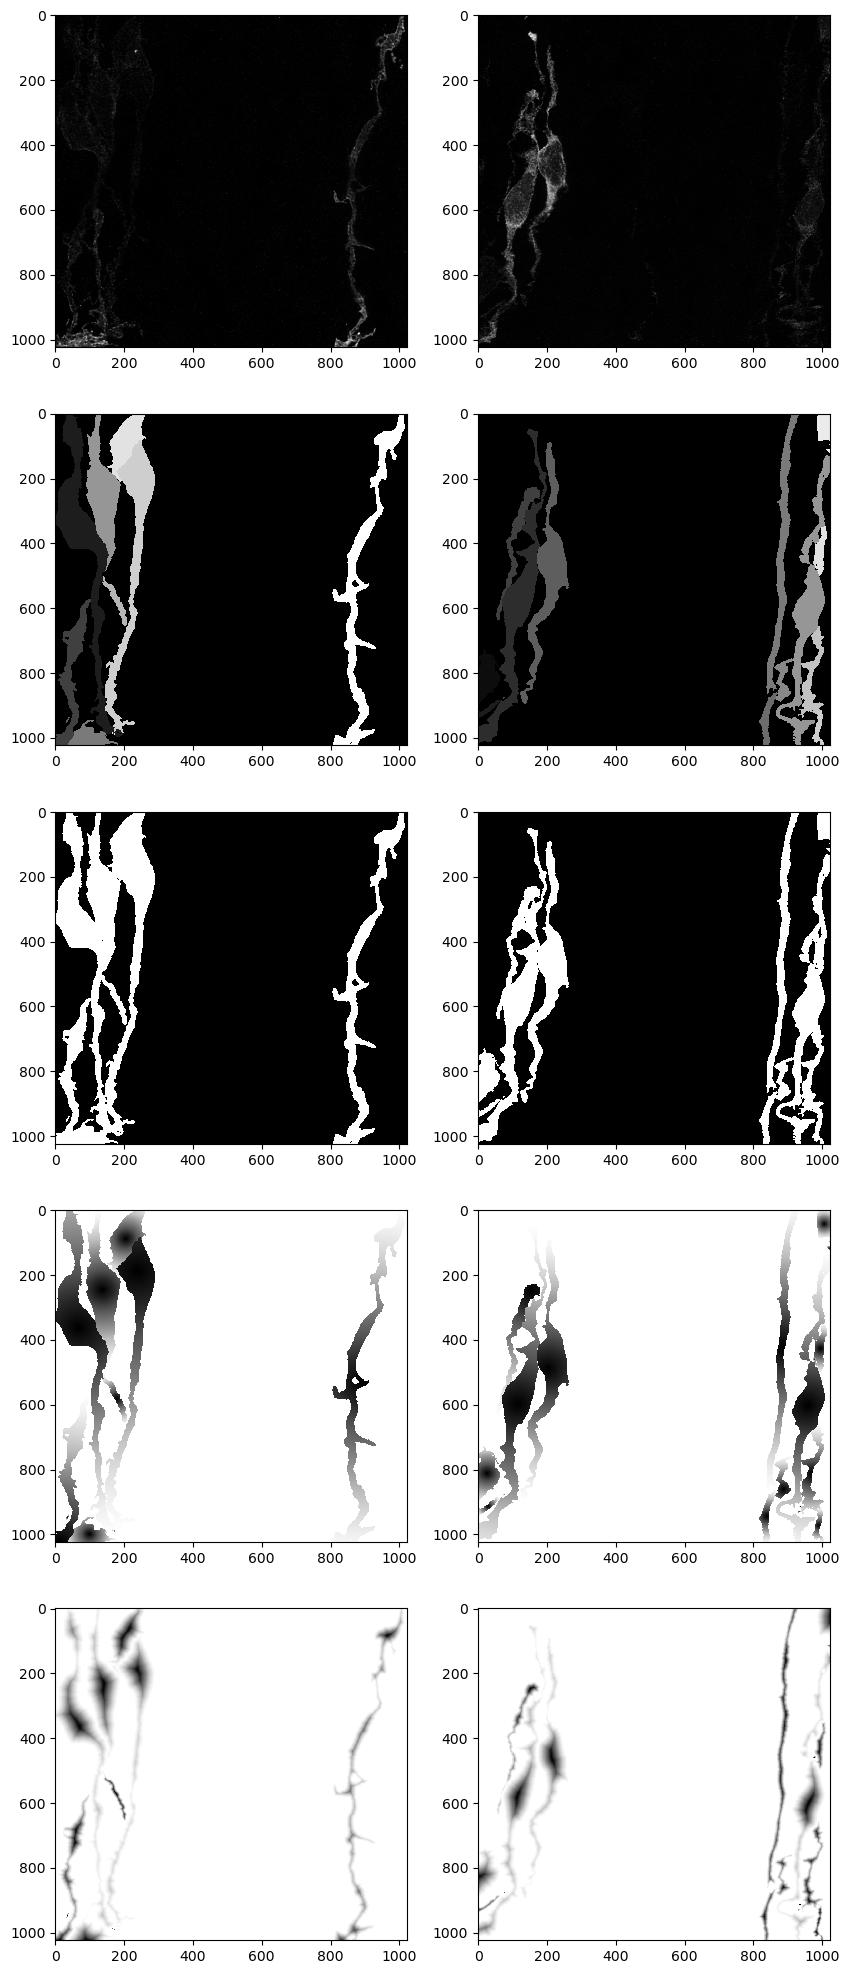

In [10]:
check_loader(train_dataloader,2, plt = True)

In [7]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 5  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = model

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = model + '---' + raw_dataset + '---' + segmentation_gt

checkpoint_name = 'test'
checkpoint_folder = 'test'

if not os.path.exists(os.path.join(root_dir, checkpoint_folder)):
    os.makedirs(os.path.join(root_dir, checkpoint_folder))

sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, checkpoint_folder),
    model_type=model_type,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

Verifying labels in 'val' dataloader:  80%|████████  | 40/50 [00:10<00:02,  3.71it/s]


Start fitting for 200 iterations /  5 epochs
with 40 iterations per epoch
Training with mixed precision


Epoch 0:   1%|          | 2/200 [00:03<04:33,  1.38s/it]

KeyboardInterrupt: 